In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import os
import random
from tqdm import tqdm
from PIL import Image
import math
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import torch.quantization


# from utils import *

In [ ]:
from google.colab import drive
drive.mount(('/content/drive'))

Mounted at /content/drive


In [ ]:
%%time

import tarfile

path = "/content/drive/MyDrive/LaPa.tar.gz"
extract_path = "/tmp"

# Open the tar.gz file
with tarfile.open(path, "r:gz") as tar:
    # Extract all contents to /tmp
    tar.extractall(path=extract_path)

CPU times: user 20.5 s, sys: 10.8 s, total: 31.4 s
Wall time: 59.3 s


In [ ]:
# Define paths to the subfolders
train_path = os.path.join("/tmp/LaPa/train")
test_path = os.path.join("/tmp/LaPa/test")
validation_path = os.path.join("/tmp/LaPa/val")

# Define paths to the images subfolder in each dataset split
train_images_path = os.path.join(train_path, "images")
test_images_path = os.path.join(test_path, "images")
validation_images_path = os.path.join(validation_path, "images")

# List files in each subfolder
print("Train files:", os.listdir(train_path))
print("Test files:", os.listdir(test_path))
print("Validation files:", os.listdir(validation_path))
print("__________________________________________")

print("Train images:", os.listdir(train_images_path))
print("Test images:", os.listdir(test_images_path))
print("Validation images:", os.listdir(validation_images_path))
print("__________________________________________")

# Define paths to the landmarks subfolder in each dataset split
train_landmarks_path = os.path.join(train_path, "landmarks")
test_landmarks_path = os.path.join(test_path, "landmarks")
validation_landmarks_path = os.path.join(validation_path, "landmarks")

print("Train landmarks:", os.listdir(train_landmarks_path))
print("Test landmarks:", os.listdir(test_landmarks_path))
print("Validation landmarks:", os.listdir(validation_landmarks_path))
print("__________________________________________")

# Define paths to the labels subfolder in each dataset split
train_labels_path = os.path.join(train_path, "labels")[:1500]
test_labels_path = os.path.join(test_path, "labels")[:400]
validation_labels_path = os.path.join(validation_path, "labels")[:200]

print("Train labels:", os.listdir(train_labels_path))
print("Test labels:", os.listdir(test_labels_path))
print("Validation labels:", os.listdir(validation_labels_path))
print("__________________________________________")

Train files: ['landmarks', 'labels', 'images']
Test files: ['landmarks', 'labels', 'images']
Validation files: ['landmarks', 'labels', 'images']
__________________________________________
Train images: ['HELEN_3160852076_1_1.jpg', 'LFPW_image_test_0087_2.jpg', '7735011206_1.jpg', 'HELEN_169598954_1_4.jpg', '6518077105_0.jpg', '8566900493_3.jpg', '200666510_6.jpg', 'HELEN_2857823310_2_0.jpg', 'HELEN_2741246020_1_9.jpg', '6000163600_0.jpg', '13751443933_7.jpg', '169604745_1.jpg', 'LFPW_image_train_0317_1.jpg', 'LFPW_image_train_0314_3.jpg', '10249158294_3.jpg', 'HELEN_185577937_1_0.jpg', '217802456_0.jpg', 'HELEN_2958855782_1_2.jpg', '4236447302_9.jpg', 'HELEN_2853185850_1_1.jpg', 'LFPW_image_train_0368_0.jpg', 'HELEN_3017468498_1_0.jpg', '3710203963_1.jpg', '4765004035_2.jpg', '6298738138_0.jpg', 'HELEN_3213087169_2_0.jpg', '278836271_0.jpg', '11887158035_0.jpg', 'LFPW_image_test_0218_2.jpg', 'HELEN_100032540_1_2.jpg', '5751992682_1.jpg', 'HELEN_2685751196_1_0.jpg', '279133288_0.jpg', '

In [ ]:
# Save checkpoint
def save_checkpoint(state,filename='weights.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

# Load checkpoint
def load_checkpoint(filename,model,optim):
    print('Loading weights-->')
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

In [ ]:
# We need to generate 1 single mask from all masks
# First we retrieve all masks associated with current image

def generate_image_from_masks(mask,original_image):
    custom_colors = np.array([
    [0, 0, 0],
    [0, 153, 255],
    [102, 255, 153],
    [0, 204, 153],
    [255, 255, 102],
    [255, 255, 204],
    [255, 153, 0],
    [255, 102, 255],
    [102, 0, 51],
    [255, 204, 255],
    [255, 0, 102]])
    h, w = mask.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            class_value = mask[y, x]
            rgb_image[y, x] = custom_colors[class_value]
    return rgb_image

def normalise_image(image): # not used currently, lets add based on performance
    # perform mean and std deviation normalization
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

In [ ]:
print((train_images_path + "/" + os.listdir(train_images_path)[0]))
print((train_labels_path + "/" + os.listdir(train_images_path)[0]).partition(".")[0] + ".png")

/tmp/LaPa/train/images/LFPW_image_train_0740_1.jpg
/tmp/LaPa/train/labels/LFPW_image_train_0740_1.png


In [ ]:
print(mask_img.shape)

(512, 512, 3)


In [ ]:
# Data Visualization
i = 21
image_path = train_images_path + "/" + os.listdir(train_images_path)[i]
mask_path = (train_labels_path + "/" + os.listdir(train_images_path)[i]).partition(".")[0] + ".png"

image_bgr = cv2.imread(image_path)
# image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
# mask_img = cv2.resize(mask_img, (512, 512))
# mask_img = generate_image_from_masks(mask_img,image_rgb)

print(image_bgr.shape)
print(mask_img.shape)

(450, 450, 3)
(450, 450)


In [ ]:
print(np.unique(mask_img))

[ 0  1  2  3  4  5  6  7  8  9 10]


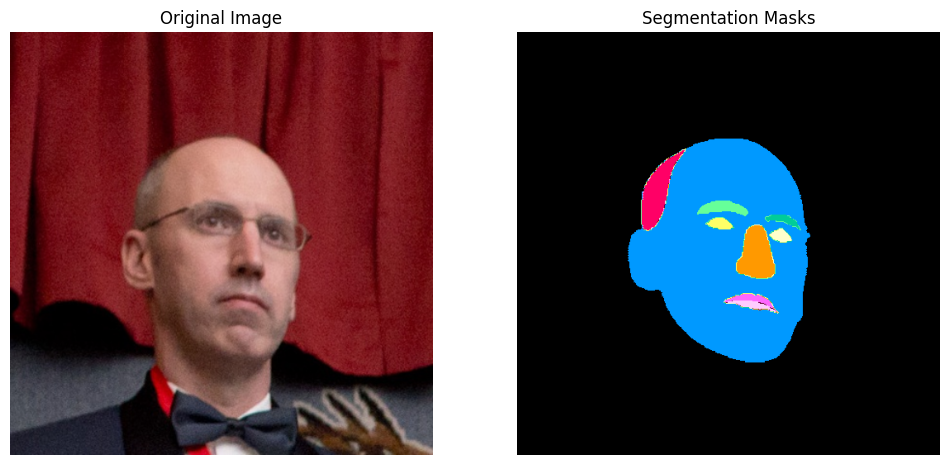

In [ ]:
# Data Visualization
i = 90
image_path = train_images_path + "/" + os.listdir(train_images_path)[i]
mask_path = (train_labels_path + "/" + os.listdir(train_images_path)[i]).partition(".")[0] + ".png"

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
mask_img = cv2.resize(mask_img, (512, 512))
mask_img = generate_image_from_masks(mask_img,image_rgb)

# Display original and mask images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
axes[0].imshow(image_rgb)  # Display original image
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axis
axes[1].imshow(mask_img)  # Display composite image with masks
axes[1].set_title('Segmentation Masks')
axes[1].axis('off')  # Hide axis
plt.show()

# Dataset creation

In [ ]:
class Lapa(Dataset):
    def __init__(self,images_dir,masks_dir,size,transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_files = os.listdir(images_dir)[:size]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.image_files[index])
        mask_path = img_path.replace("images","labels").replace("jpg","png")
        # Open image
        image = Image.open(img_path)
        # Open masks - create 1 mask or N masks???? N mask for ground truth and N masks from CNN seems like a better design choice
        mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask_img = cv2.resize(mask_img, (512, 512))
        # Split the masks
        binary_masks = []

        # Iterate over each class
        for class_value in range(0, 11):
            # Create a binary mask for the current class
            binary_mask = (mask_img == class_value).astype(np.float32)
            binary_masks.append(binary_mask)
        # convert to tensor
        torch_tensors_list = [torch.tensor(mask) for mask in binary_masks]
        return self.transform(image), torch.stack(torch_tensors_list, dim=0)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the image
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class SynchronizedTransform():
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.ToTensor()
        ])

        self.normalize = transforms.Compose([
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])

    def __call__(self, image, masks):
        seed = random.randint(0, 2**32)

        random.seed(seed)
        torch.manual_seed(seed)
        image = self.transform(image)
        image = self.normalize(image)

        random.seed(seed)
        torch.manual_seed(seed)
        masks = self.transform(masks)

        return image, masks

In [ ]:
# Define the Transform Customly - as when we do random flips on img, these flips should happen on mask as well
class CustomTransform():
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        # Resize
        image = transforms.functional.resize(image,[512,512])
        # Random horizontal and vertical flipping
        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)
        if random.random() > 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)
        # Convert PIL images to PyTorch tensors
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        return image,mask

In [ ]:
image_files = os.listdir(train_images_path)
print(image_files)

['LFPW_image_train_0740_1.jpg', '4832818348_1.jpg', 'HELEN_2534288728_1_1.jpg', '3735180332_0.jpg', '2348319657_0.jpg', '7799715496_0.jpg', 'HELEN_3179878396_1_0.jpg', '165460606_1.jpg', '13920981282_0.jpg', '10515277104_0.jpg', '462884827_0.jpg', 'HELEN_172183000_1_1.jpg', '14016853103_0.jpg', '12479470275_5.jpg', '2098076625_14.jpg', 'HELEN_3080573833_1_1.jpg', 'HELEN_2685751196_1_0.jpg', 'HELEN_3217491791_1_0.jpg', '1259094191_0.jpg', 'HELEN_2983659912_1_1.jpg', 'HELEN_2127986751_1_0.jpg', 'HELEN_10405424_1_0.jpg', 'HELEN_2168442533_1_0.jpg', 'HELEN_2936371718_1_3.jpg', 'HELEN_2783667002_1_2.jpg', 'HELEN_276823387_1_4.jpg', '3972174723_5.jpg', 'HELEN_1895136013_1_1.jpg', 'HELEN_2880878213_1_0.jpg', '2895520758_4.jpg', 'HELEN_1507775914_1_1.jpg', 'HELEN_2739463536_1_1.jpg', '2448842362_11.jpg', 'HELEN_182804431_1_1.jpg', '6041686014_0.jpg', 'HELEN_1385689774_1_0.jpg', 'HELEN_2815981843_2_3.jpg', 'LFPW_image_train_0669_3.jpg', '4625333004_7.jpg', '10059815886_1.jpg', 'LFPW_image_train

In [ ]:
type(image_files)

list

In [ ]:
# Create datasets
train_dataset = Lapa(train_images_path,
                    train_labels_path,
                    1100,
                    transform)

val_dataset = Lapa(validation_images_path,
                   validation_labels_path,
                   250,
                   transform)

In [ ]:
len(train_dataset)

1000

In [ ]:
prima_img = np.array(train_dataset[1][0].permute(1,2,0))

In [ ]:
tensor = train_dataset[1][1]

In [ ]:
isinstance(tensor, torch.Tensor)

True

In [ ]:
prima_mask = np.array(train_dataset[1][1])

In [ ]:
msk1 = prima_mask[0]

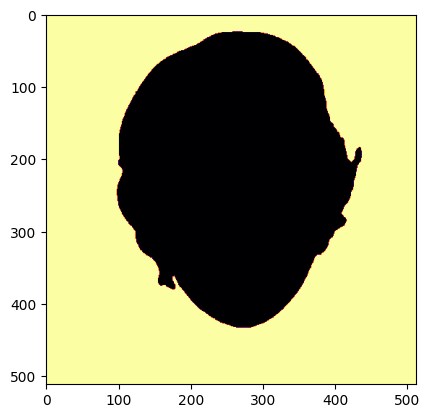

In [ ]:
plt.imshow(msk1, cmap = 'inferno')

In [ ]:
msk2 = prima_mask[1]

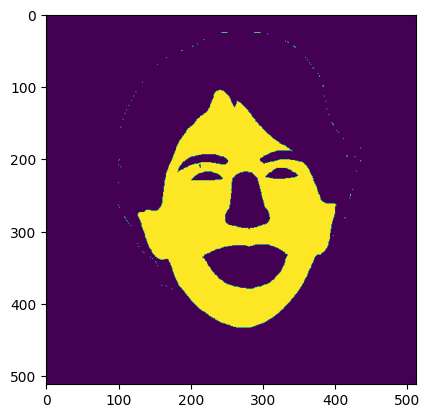

In [ ]:
plt.imshow(msk2)

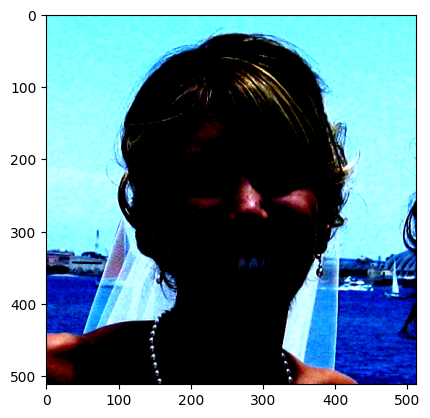

In [ ]:
plt.imshow(prima_img)

# Dataloader and co

In [ ]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Custom loss function that takes BCE and Dice Coefficient
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, y_pred, y_truth):
        assert y_pred.shape == y_truth.shape
        return self.bce_loss(y_pred, y_truth)

In [ ]:
def train_loop(model,dataloader,loss_fun,optimizer,device):
    model.train()
    model.to(device)
    min_loss = None
    for epoch in range(num_epochs):
        losses = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # calculate loss & accuracy
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # zero out prior gradients
            optimizer.zero_grad()

            # backprop
            loss.backward()

            # update weights
            optimizer.step()
            scheduler.step()

            # Update TQDM progress bar
            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item())

        moving_loss = sum(losses) / len(losses)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # Save check point
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1}'.format(epoch + 1, moving_loss))

In [ ]:
def test_loop(model,dataloader,loss_fun,device):
    model.eval()
    model.to(device)
    losses = []
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # caclulate test loss
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

# Deep Residual Network

In [ ]:
import torch
import torch.nn as nn

class ResUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=11, f = [64, 128, 256, 512]):
        super(ResUNet, self).__init__()

        # Encoding
        self.input_block_layer = self.input_block(in_channels, 64)
        self.input_skip_layer = self.input_skip(in_channels, 64)

        self.db_conv1 = self.double_conv(64, 128)
        self.skip1 = self.skip(64, 128)

        self.db_conv2 = self.double_conv(128, 256)
        self.skip2 = self.skip(128, 256)

        # self.db_conv3 = self.double_conv(256, 512)
        # self.skip3 = self.skip(256, 512)

        # Bridge
        self.bridge_layer = self.double_conv(256, 512)
        # self.bridge_layer = self.bridge(256)

        # Decoding
        self.up_1_layer = self.upsample(512)
        self.db_conv4 = self.double_conv(512 + 256, 256, stride = 1)
        self.skip4 = self.skip(512 + 256, 256, stride = 1)

        self.up_2_layer = self.upsample(256)
        self.db_conv5 = self.double_conv(256 + 128, 128, stride = 1)
        self.skip5 = self.skip(256 + 128, 128, stride = 1)

        self.up_3_layer = self.upsample(128)
        self.db_conv6 = self.double_conv(128 + 64, 64, stride = 1)
        self.skip6 = self.skip(128 + 64, 64, stride = 1)

        self.final_conv = nn.Sequential(
            nn.Conv2d(64, num_classes, 1, 1),
            nn.Sigmoid(),
        )

    def bridge(self, channels, kernel_size=3, stride=1):
        bridge = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=2, padding=1), # try stride 2
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=1),
        )
        return bridge

    def input_block(self, in_channels, out_channels):
        input_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', stride=1),
        )
        return input_block

    def input_skip(self, in_channels, out_channels):
        input_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same')
        )
        return input_skip

    def double_conv(self, in_channels, out_channels, kernel_size=3, stride=2):
        conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride = 1, padding=1),
        )
        return conv_block

    def skip(self, in_channels, out_channels, kernel_size=3, stride=2):
        conv_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        return conv_skip

    def upsample(self, channels): # non cambia il numero di canali
        return nn.ConvTranspose2d(channels, channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encode
        x1 = self.input_block_layer(x) + self.input_skip_layer(x)
        # print('x1', x1.shape)
        x2 = self.db_conv1(x1) + self.skip1(x1)
        # print('x2', x2.shape)
        x3 = self.db_conv2(x2) + self.skip2(x2)
        # print('x3', x3.shape)
        # x4 = self.db_conv3(x3) + self.skip3(x3)
        # print('x4', x4.shape)


        # Bridge
        x4 = self.bridge_layer(x3)
        # print('x4', x4.shape)

        # Decode
        x5 = self.up_1_layer(x4)
        # print('x5', x5.shape)
        x6 = torch.cat([x3, x5], dim=1)
        # print('x6', x6.shape)
        x7 = self.db_conv4(x6) + self.skip4(x6)
        # print('x7', x7.shape)

        x8 = self.up_2_layer(x7)
        # print('x8', x8.shape)
        x9 = torch.cat([x8, x2], dim=1)
        # print('x9', x9.shape)
        x10 = self.db_conv5(x9) + self.skip5(x9)
        # print('x10', x10.shape)

        x11 = self.up_3_layer(x10)
        # print('x11', x11.shape)
        x12 = torch.cat([x1, x11], dim=1)
        # print('x12', x12.shape)
        x13 = self.db_conv6(x12) + self.skip6(x12)
        # print('x13', x13.shape)


        output = self.final_conv(x13)

        return output


In [ ]:
model = ResUNet(in_channels=3, num_classes=11)
x = torch.randn(2, 3, 512, 512)  # Example input tensor
output = model(x)
print(output.shape)

KeyboardInterrupt: 

In [ ]:
# Params
learning_rate = 0.00005
num_epochs = 5
num_workers = 2
batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on: ',device)

Running on:  cuda


In [ ]:
# Define Criterion, Loss function, LR Scheduler
model = ResUNet(in_channels=3, num_classes=11)
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [ ]:
train_loop(model,train_loader,criterion,optimizer,device)

  0%|          | 0/550 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 

In [ ]:
test_loop(model, val_loader, criterion, device)

In [ ]:
image, mask = next(iter(val_loader))
image, mask = image.to(device), mask.to(device)
model.eval()
pred = model(image)

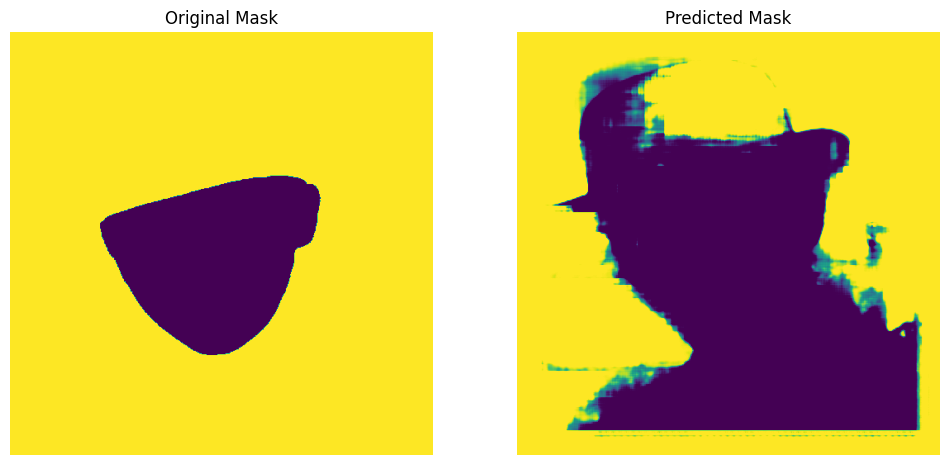

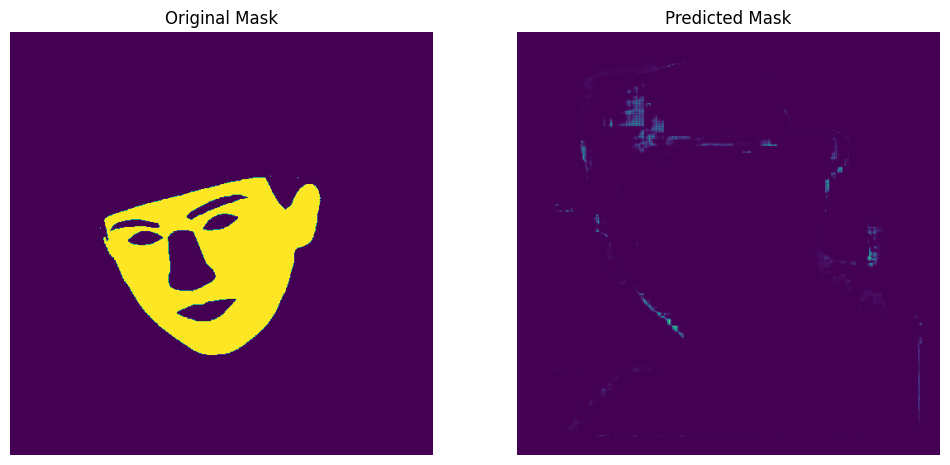

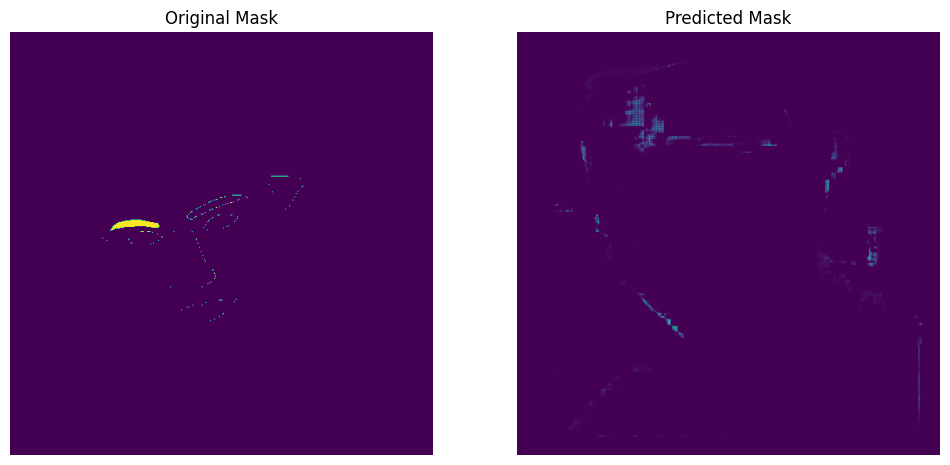

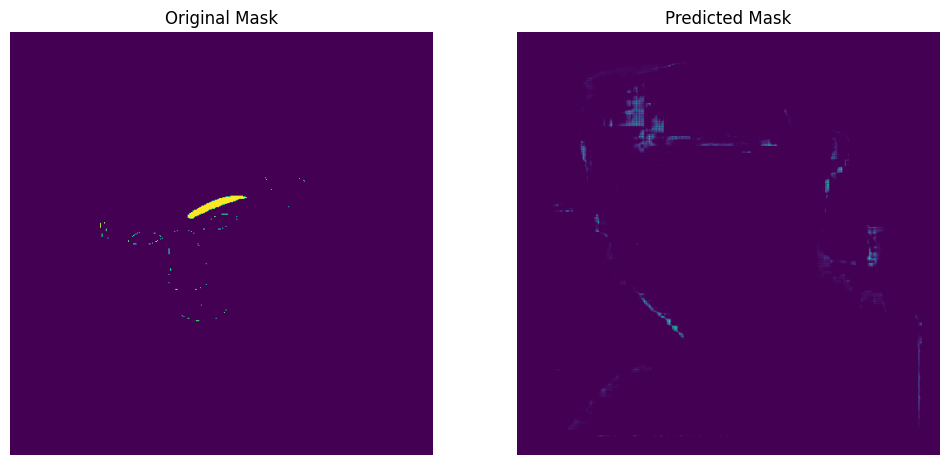

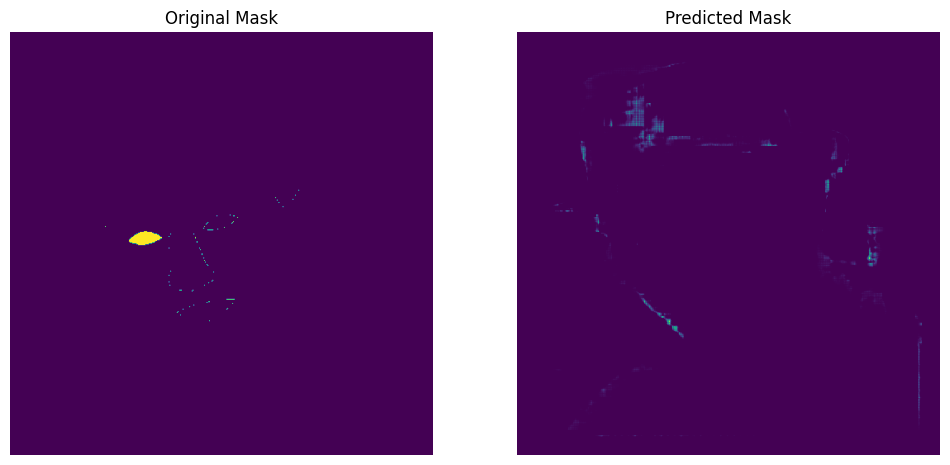

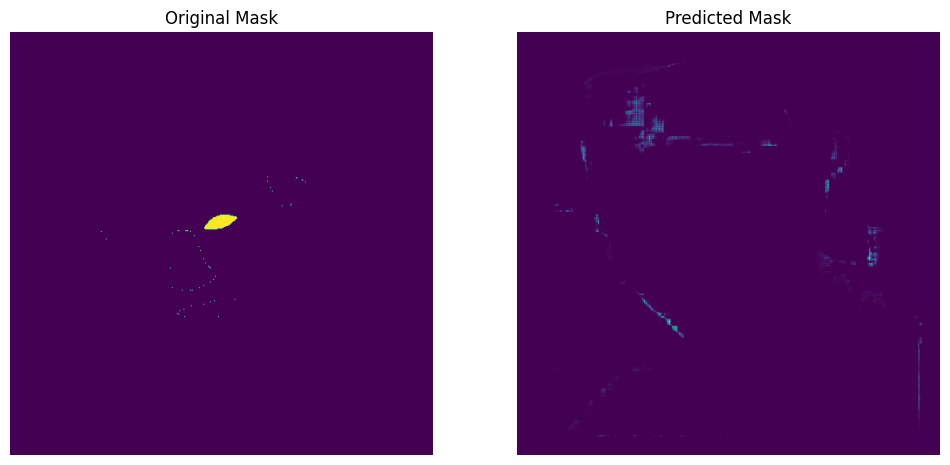

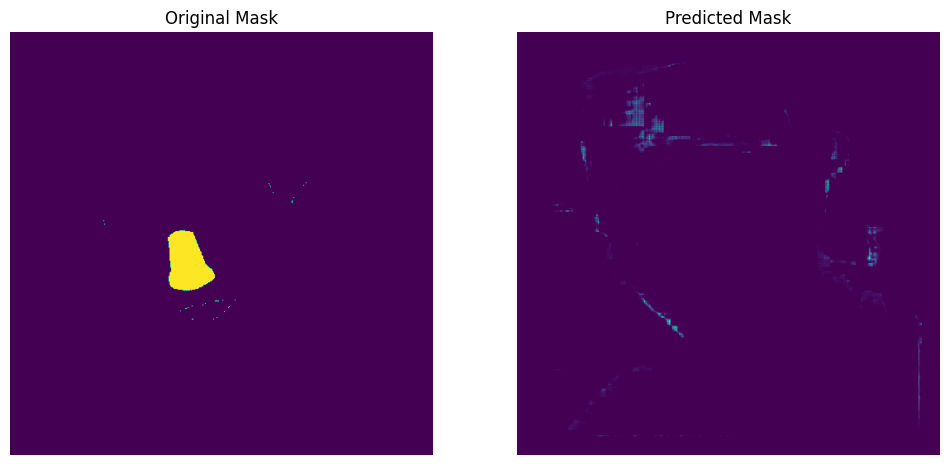

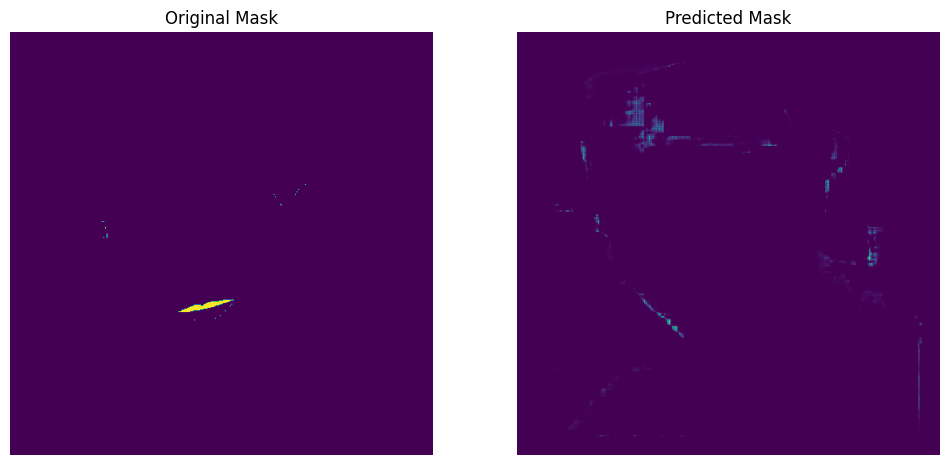

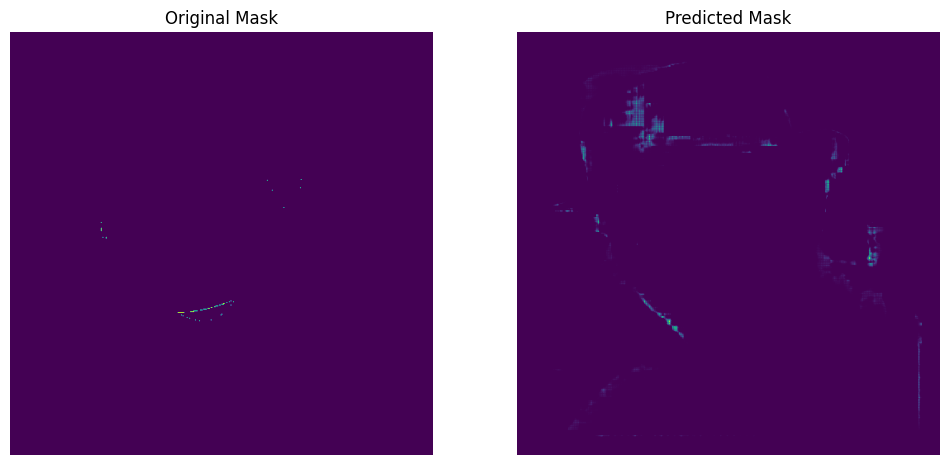

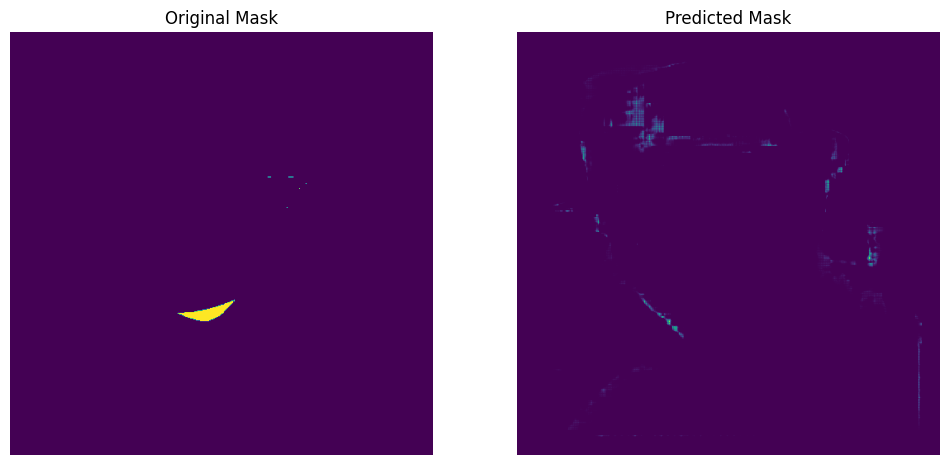

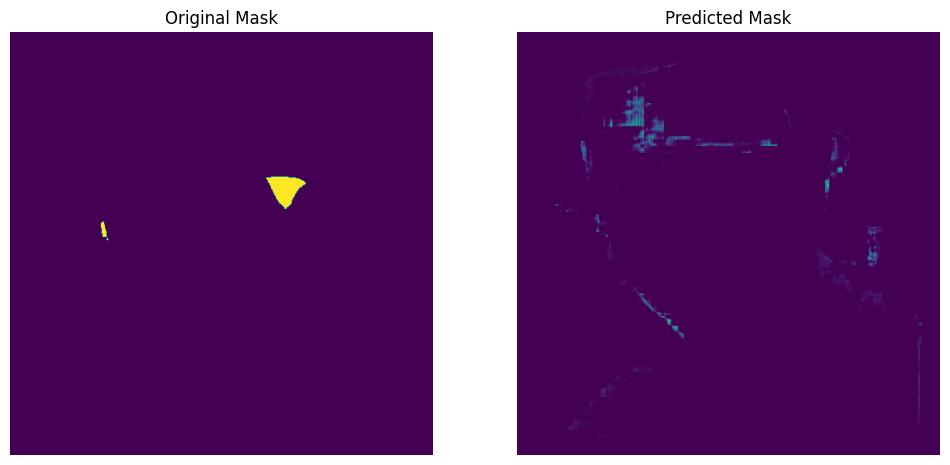

In [ ]:
for i in range(0, 11):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
  axes[0].imshow(mask[0][i].cpu())  # Display original image
  axes[0].set_title('Original Mask')
  axes[0].axis('off')  # Hide axis
  axes[1].imshow(pred[0][i].detach().cpu().numpy())  # Display composite image with masks
  axes[1].set_title('Predicted Mask')
  axes[1].axis('off')  # Hide axis
  plt.show()

# DRSUNet

In [ ]:
# Depth Residual Seperable UNet
# Different from VanillaUNet - has skip connections inside Conv blocks, uses Depth Seperable Conv ops
# resulting in lesser computations

class DRSUNet(nn.Module):
    def __init__(self,in_channels=3,num_classes=11):
        super(DRSUNet, self).__init__()
        # Encode architecture
        self.dsconv1_1 = self._depth_seperable_conv(in_channels, 64)
        self.dsconv1_2 = self._depth_seperable_conv(64, 64)
        self.dsconv2_1 = self._depth_seperable_conv(64, 64)
        self.dsconv2_2 = self._depth_seperable_conv(128, 128)
        self.dsconv3_1 = self._depth_seperable_conv(128, 128)
        self.dsconv3_2 = self._depth_seperable_conv(256, 256)
        self.dsconv4_1 = self._depth_seperable_conv(256, 256)
        self.dsconv4_2 = self._depth_seperable_conv(512, 512)
        self.dsconv5_1 = self._depth_seperable_conv(512, 512)
        self.dsconv5_2 = self._depth_seperable_conv(1024, 1024)
        # Decoder architecture
        self.uconv1 = nn.ConvTranspose2d(1024,512,stride=2,kernel_size=2)
        self.dconv6 = self._double_conv(1024, 512)
        self.uconv2 = nn.ConvTranspose2d(512, 256,stride=2,kernel_size=2)
        self.dconv7 = self._double_conv(512, 256)
        self.uconv3 = nn.ConvTranspose2d(256, 128,stride=2,kernel_size=2)
        self.dconv8 = self._double_conv(256, 128)
        self.uconv4 = nn.ConvTranspose2d(128, 64,stride=2,kernel_size=2)
        self.dconv9 = self._double_conv(128, 64)
        # Final conv
        self.final_conv = nn.Conv2d(64,num_classes,kernel_size=1)
        # Max pool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _depth_seperable_conv(self, in_channels, out_channels):
        # Modifying Conv2d such that it performs 2 operations
        # 1. Depth wise convolution
        # 2. Point wise convolution
        # The 2 consecutive Conv2d represent the Depth Wise & Point Wise Conv operations respectively
        depth_seperable_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, groups=in_channels, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return depth_seperable_conv

    def _double_conv(self, in_channels,out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, groups=in_channels, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, groups=out_channels, kernel_size=3, padding='same'),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return conv

    def forward(self,X0):
        # Forward Prop thru Encoder
        # X Shape : [B X 3 X 512 X 512]
        X1 = self.dsconv1_1(X0)          # X1 Shape : [B X 64 X 512 X 512]
        X2 = self.dsconv1_2(X1)          # X2 Shape : [B X 64 X 512 X 512]

        X3 = self.max_pool(X2)           # X3 Shape : [B X 64 X 256 X 256]

        X4 = self.dsconv2_1(X3)          # X4 Shape : [B X 64 X 256 X 256]
        X5 = torch.cat((X3,X4),dim=1)    # X5 Shape : [B X 128 X 256 X 256]
        X6 = self.dsconv2_2(X5)          # X6 Shape : [B X 128 X 256 X 256]

        X7 = self.max_pool(X6)           # X7 Shape : [B X 128 X 128 X 128]

        X8 = self.dsconv3_1(X7)          # X8 Shape : [B X 128 X 128 X 128]
        X9 = torch.cat((X7,X8),dim=1)    # X9 Shape : [B X 256 X 128 X 128]
        X10 = self.dsconv3_2(X9)         # X10 Shape : [B X 256 X 128 X 128]

        X11 = self.max_pool(X10)         # X11 Shape : [B X 256 X 64 X 64]

        X12 = self.dsconv4_1(X11)        # X12 Shape : [B X 256 X 64 X 64]
        X13 = torch.cat((X11,X12),dim=1) # X13 Shape : [B X 512 X 64 X 64]
        X14 = self.dsconv4_2(X13)        # X14 Shape : [B X 512 X 64 X 64]

        X15 = self.max_pool(X14)         # X15 Shape : [B X 512 X 32 X 32]

        X16 = self.dsconv5_1(X15)        # X16 Shape : [B X 512 X 32 X 32]
        X17 = torch.cat((X15,X16),dim=1) # X17 Shape : [B X 1024 X 32 X 32]
        X18 = self.dsconv5_2(X17)        # X18 Shape : [B X 1024 X 32 X 32]

        # Forward Prop thru Decoder
        X19 = self.uconv1(X18)           # X19 Shape : [B X 512 X 64 X 64]
        X20 = torch.cat((X19,X14),dim=1) # X20 Shape : [B X 1024 X 64 X 64]
        X21 = self.dconv6(X20)           # X21 Shape : [B X 512 X 64 X 64]

        X22 = self.uconv2(X21)           # X22 Shape : [B X 256 X 128 X 128]
        X23 = torch.cat((X22,X10),dim=1) # X23 Shape : [B X 512 X 128 X 128]
        X24 = self.dconv7(X23)           # X24 Shape : [B X 256 X 128 X 128]

        X25 = self.uconv3(X24)            # X25 Shape : [B X 128 X 256 X 256]
        X26 = torch.cat((X25,X6),dim=1)   # X26 Shape : [B X 256 X 256 X 256]
        X27 = self.dconv8(X26)            # X27 Shape : [B X 128 X 256 X 256]

        X28 = self.uconv4(X27)            # X28 Shape : [B X 64 X 512 X 512]
        X29 = torch.cat((X28,X2),dim=1)   # X29 Shape : [B X 128 X 512 X 512]
        X30 = self.dconv9(X29)            # X30 Shape : [B X 64 X 512 X 512]

        # Final Conv Layer
        X31 = self.final_conv(X30)        # X31 Shape : [B X num_classes X 512 X 512]

        return F.softmax(X31,dim=1)

In [ ]:
len(val_dataset)

2000

In [ ]:
# Params
learning_rate = 0.001
num_epochs = 25
num_workers = 2
batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on: ',device)

Running on:  cuda


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Instantiate model
model = DRSUNet(in_channels=3,num_classes=11)

NameError: name 'DRSUNet' is not defined

## a

In [ ]:
model = ResUNet(in_channels=3,num_classes=11)

ValueError: padding='same' is not supported for strided convolutions

In [ ]:
# Custom loss function that takes BCE and Dice Coefficient
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, y_pred, y_truth):
        assert y_pred.shape == y_truth.shape
        return self.bce_loss(y_pred, y_truth)

In [ ]:
# Define Criterion, Loss function, LR Scheduler
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [ ]:
x,y = next(iter(train_loader))
print(x.shape,y.shape)
# ignore warnings - some images do not have all 10 segment masks

torch.Size([2, 3, 512, 512]) torch.Size([2, 11, 512, 512])


In [ ]:
model.to(device)
x = x.to(device)
y = y.to(device)
print()

In [ ]:
print(y[1].unique())

tensor([0., 1.], device='cuda:0')


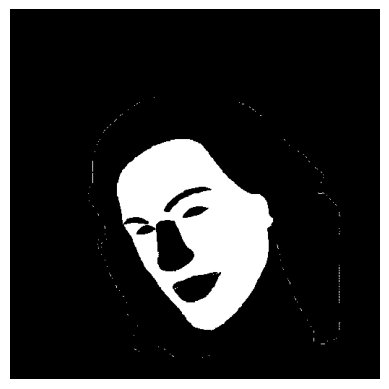

In [ ]:
# sample mask
image_tensor = y[1][1]
image_array = image_tensor.cpu().numpy()

# Display the grayscale image using Matplotlib
plt.imshow(image_array, cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
y_pred = model(x)
print(y_pred.shape,y.shape)

torch.Size([2, 11, 512, 512]) torch.Size([2, 11, 512, 512])


In [ ]:
load_checkpoint("/kaggle/working/weights.pth.tar",model,optimizer) ###??? da dove???

Loading weights-->


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/weights.pth.tar'

In [ ]:
train_loop(model,train_loader,criterion,optimizer,device)

Epoch [0/25] :  18%|█▊        | 1606/9084 [10:24<48:29,  2.57it/s, loss=0.667]  


KeyboardInterrupt: 

In [ ]:
test_loop(model,val_loader,criterion,device)

# U-net

In [ ]:
# Define segmentation architectures
class VanillaUNet(nn.Module):
    def __init__(self,in_channels=3,num_classes=11):
        super(VanillaUNet, self).__init__()
        # Encode architecture
        self.dconv1 = self._double_conv(in_channels, 64)
        self.dconv2 = self._double_conv(64, 128)
        self.dconv3 = self._double_conv(128, 256)
        self.dconv4 = self._double_conv(256, 512)
        self.dconv5 = self._double_conv(512, 1024)
        # Decoder architecture
        self.uconv1 = nn.ConvTranspose2d(1024,512,stride=2,kernel_size=2)
        self.dconv6 = self._double_conv(1024, 512)
        self.uconv2 = nn.ConvTranspose2d(512,256,stride=2,kernel_size=2)
        self.dconv7 = self._double_conv(512, 256)
        self.uconv3 = nn.ConvTranspose2d(256,128,stride=2,kernel_size=2)
        self.dconv8 = self._double_conv(256, 128)
        self.uconv4 = nn.ConvTranspose2d(128,64,stride=2,kernel_size=2)
        self.dconv9 = self._double_conv(128, 64)
        # Final conv
        self.final_conv = nn.Conv2d(64,num_classes,kernel_size=1)
        # Max pool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return conv

    def forward(self,X):
        # Forward Prop thru Encoder
        # X Shape : [B X 3 X 512 X 512]
        X1 = self.dconv1(X)              # X1 Shape : [B X 64 X 512 X 512]
        X2 = self.max_pool(X1)           # X2 Shape : [B X 64 X 256 X 256]

        X3 = self.dconv2(X2)             # X3 Shape : [B X 128 X 256 X 256]
        X4 = self.max_pool(X3)           # X4 Shape : [B X 128 X 128 X 128]

        X5 = self.dconv3(X4)             # X5 Shape : [B X 256 X 128 X 128]
        X6 = self.max_pool(X5)           # X6 Shape : [B X 256 X 64 X 64]

        X7 = self.dconv4(X6)             # X7 Shape : [B X 512 X 64 X 64]
        X8 = self.max_pool(X7)           # X8 Shape : [B X 512 X 32 X 32]

        X9 = self.dconv5(X8)             # X9 Shape : [B X 1024 X 32 X 32]

        # Forward Prop thru Decoder
        X10 = self.uconv1(X9)            # X10 Shape : [B X 512 X 64 X 64]
        X11 = torch.cat((X10,X7),dim=1)  # X11 Shape : [B X 1024 X 64 X 64]
        X12 = self.dconv6(X11)           # X12 Shape : [B X 512 X 64 X 64]

        X13 = self.uconv2(X12)           # X13 Shape : [B X 256 X 128 X 128]
        X14 = torch.cat((X13,X5),dim=1)  # X14 Shape : [B X 512 X 128 X 128]
        X15 = self.dconv7(X14)           # X15 Shape : [B X 256 X 128 X 128]

        X16 = self.uconv3(X15)            # X16 Shape : [B X 128 X 256 X 256]
        X17 = torch.cat((X16,X3),dim=1)   # X17 Shape : [B X 256 X 256 X 256]
        X18 = self.dconv8(X17)            # X18 Shape : [B X 128 X 256 X 256]

        X19 = self.uconv4(X18)            # X19 Shape : [B X 64 X 512 X 512]
        X20 = torch.cat((X19,X1),dim=1)   # X20 Shape : [B X 128 X 512 X 512]
        X21 = self.dconv9(X20)            # X21 Shape : [B X 64 X 512 X 512]

        # Final Conv Layer
        X22 = self.final_conv(X21)        # X22 Shape : [B X num_classes X 512 X 512]

        return F.softmax(X22,dim=1)

In [ ]:
model = VanillaUNet(in_channels=3,num_classes=11).to(device)

In [ ]:
# Define Criterion, Loss function, LR Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [ ]:
def train_loop(model,dataloader,loss_fun,optimizer,device):
    model.train()
    model.to(device)
    min_loss = None
    for epoch in range(5):
        losses = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # calculate loss & accuracy
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # zero out prior gradients
            optimizer.zero_grad()

            # backprop
            loss.backward()

            # update weights
            optimizer.step()
            scheduler.step()

            # Update TQDM progress bar
            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item())

        moving_loss = sum(losses) / len(losses)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # Save check point
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1}'.format(epoch, moving_loss))

In [ ]:
train_loop(model,train_loader,criterion,optimizer,device)

Epoch [0/25] : 100%|██████████| 550/550 [04:57<00:00,  1.85it/s, loss=0.685]


Saving weights-->
Epoch 0 : Loss = 0.680105880390514


Epoch [1/25] : 100%|██████████| 550/550 [04:53<00:00,  1.87it/s, loss=0.674]


Saving weights-->
Epoch 1 : Loss = 0.6785350088639693


Epoch [2/25] : 100%|██████████| 550/550 [04:53<00:00,  1.87it/s, loss=0.672]


Saving weights-->
Epoch 2 : Loss = 0.6776084390553561


Epoch [3/25] : 100%|██████████| 550/550 [04:52<00:00,  1.88it/s, loss=0.673]


Epoch 3 : Loss = 0.6776158068396828


Epoch [4/25] : 100%|██████████| 550/550 [04:52<00:00,  1.88it/s, loss=0.686]


Saving weights-->
Epoch 4 : Loss = 0.6768703140995719


In [ ]:
def test_loop(model,dataloader,loss_fun,device):
    model.eval()
    model.to(device)
    losses = []
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # caclulate test loss
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

In [ ]:
test_loop(model, val_loader, criterion,device)

100%|██████████| 125/125 [00:28<00:00,  4.45it/s, loss=0.684]


In [ ]:
image, mask = next(iter(val_loader))
image, mask = image.to(device), mask.to(device)

In [ ]:
image, mask = next(iter(val_loader))
image, mask = image.to(device), mask.to(device)
model.eval()
pred = model(image)

In [ ]:
iou_scores, dice_scores, mIoU = compute_metrics(pred, mask)

In [ ]:
print(iou_scores, dice_scores, mIoU)

[tensor(0.0909), tensor(0.0909)] [tensor(1.), tensor(1.)] 0.09090909


In [ ]:
def compute_metrics(pred_masks, true_masks):
    iou_scores = []
    dice_scores = []

    for pred_mask, true_mask in zip(pred_masks, true_masks):
        pred_mask, true_mask = pred_mask.detach().cpu(), true_mask.cpu()
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        iou = intersection / union if union != 0 else 0
        iou_scores.append(iou)

        dice = 2 * intersection / (pred_mask.sum() + true_mask.sum())
        dice_scores.append(dice)

    mIoU = np.mean(iou_scores)

    return iou_scores, dice_scores, mIoU

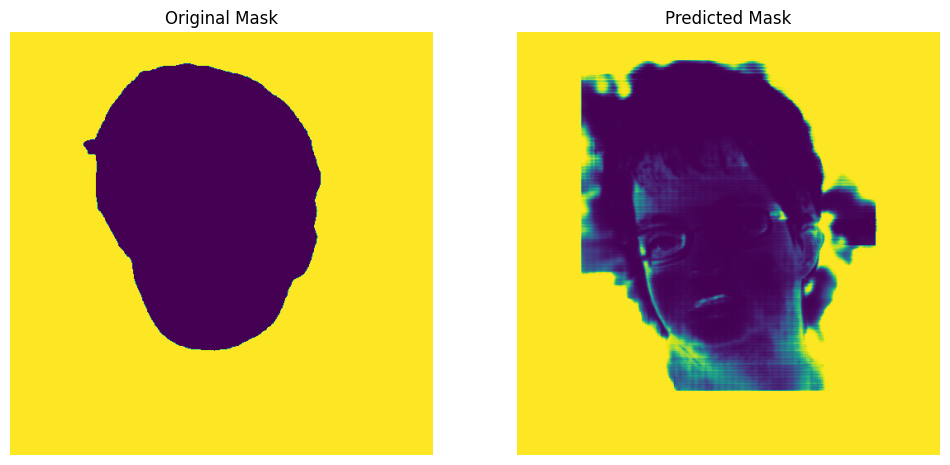

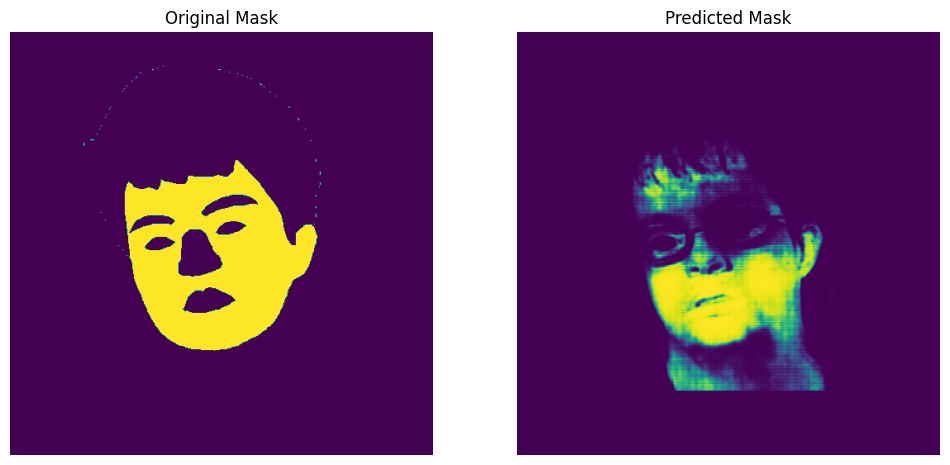

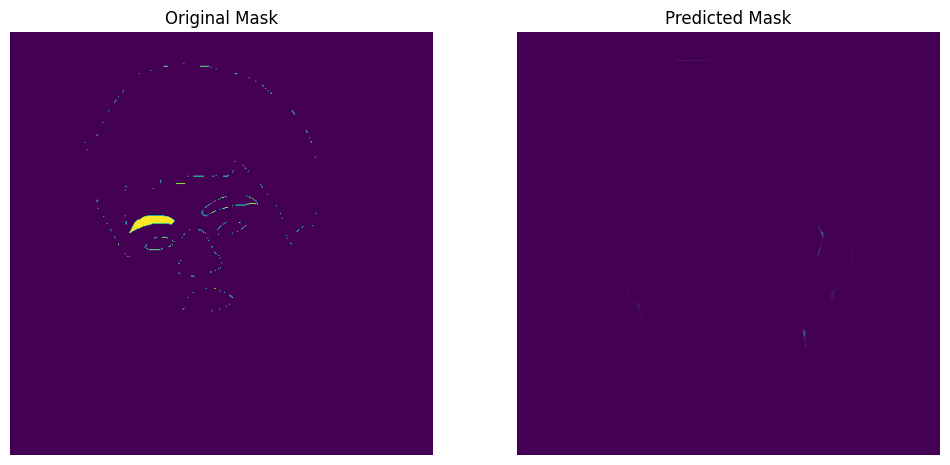

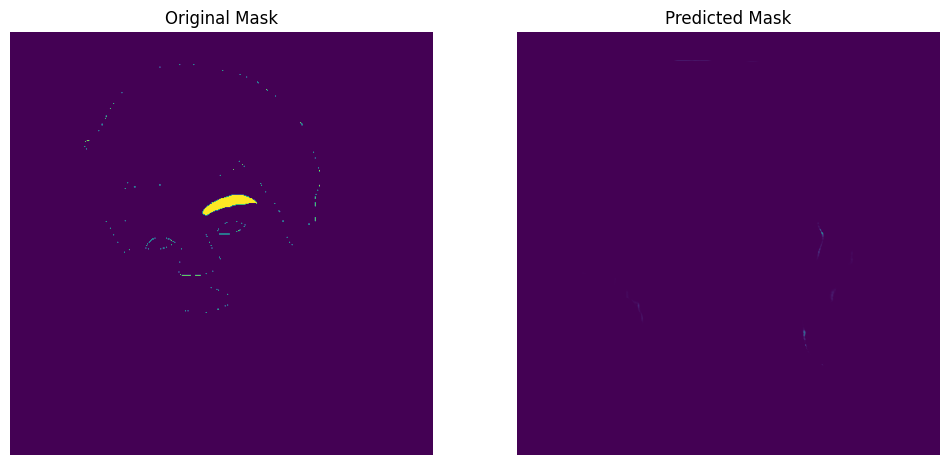

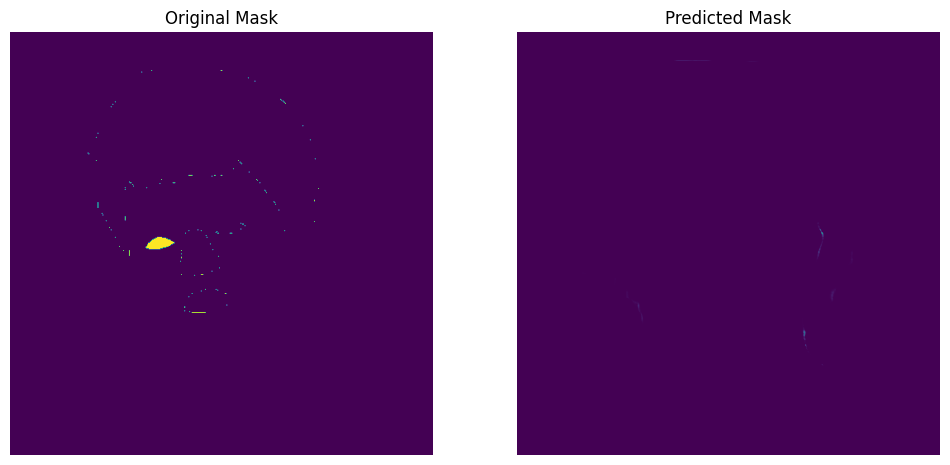

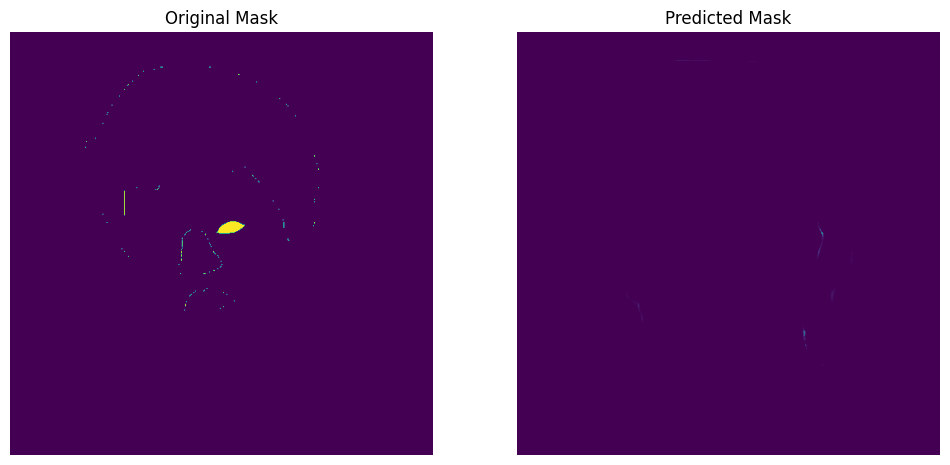

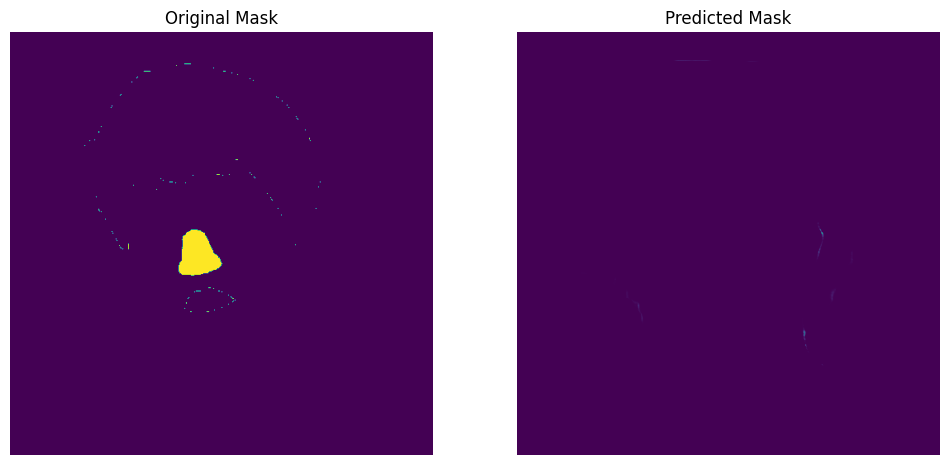

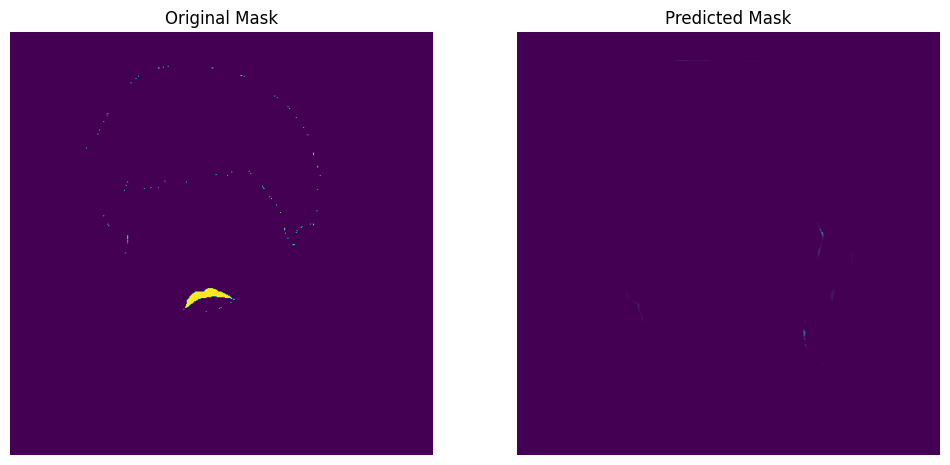

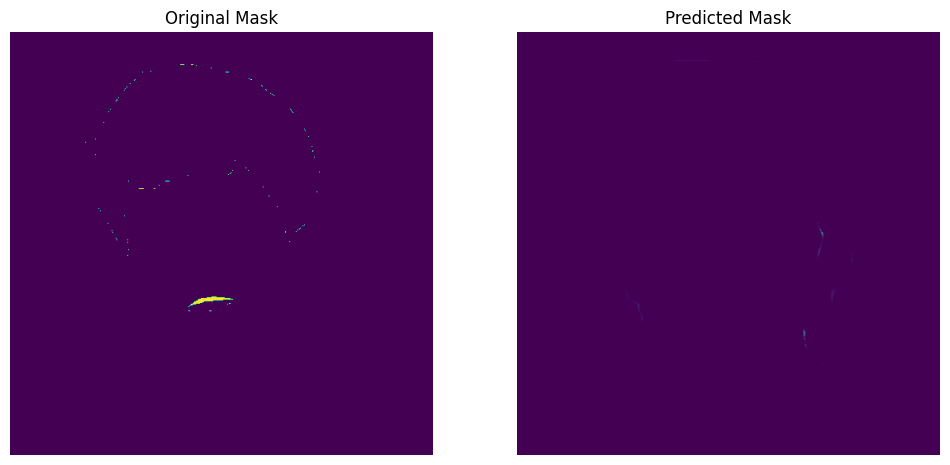

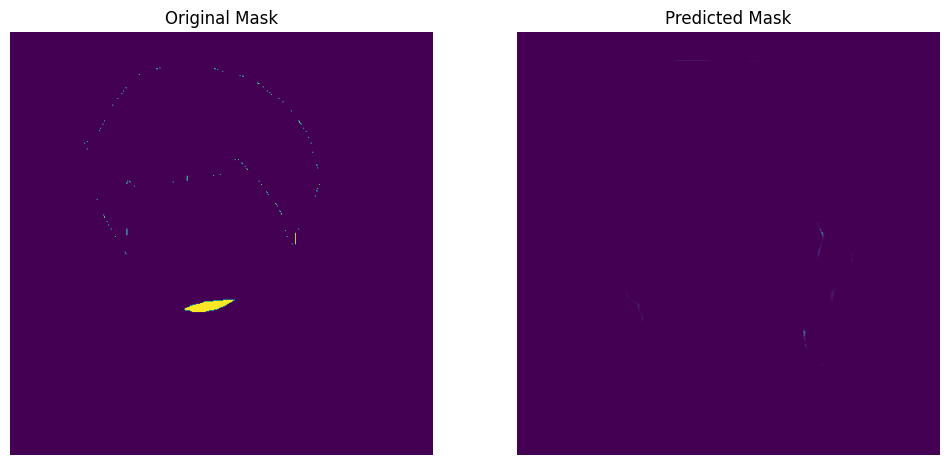

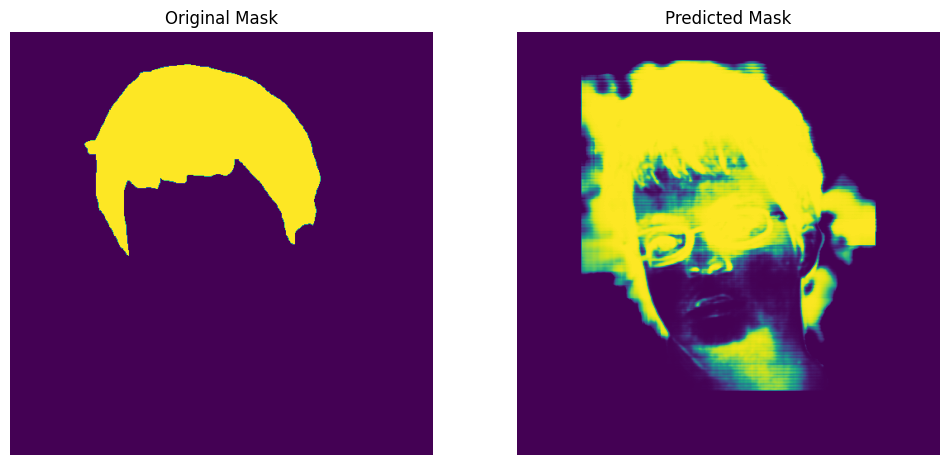

In [ ]:
for i in range(0, 11):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
  axes[0].imshow(mask[0][i].cpu())  # Display original image
  axes[0].set_title('Original Mask')
  axes[0].axis('off')  # Hide axis
  axes[1].imshow(pred[0][i].detach().cpu().numpy())  # Display composite image with masks
  axes[1].set_title('Predicted Mask')
  axes[1].axis('off')  # Hide axis
  plt.show()

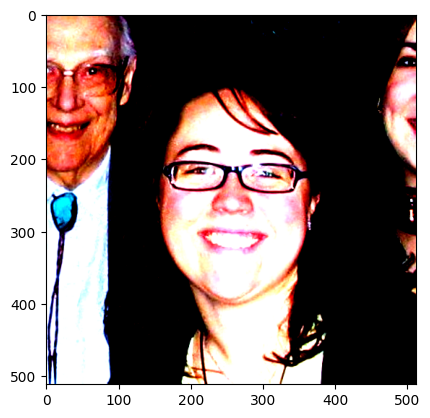

In [ ]:
img = np.array(image[1].permute(1,2,0).cpu())
plt.imshow(img)

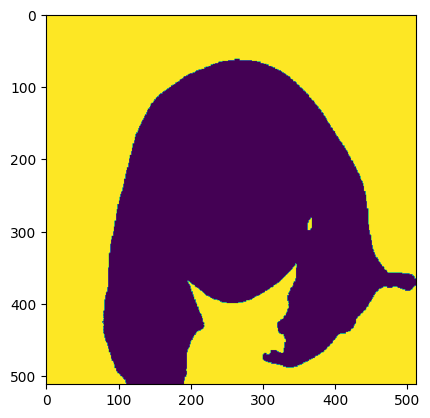

In [ ]:
plt.imshow(mask[1][0].cpu())

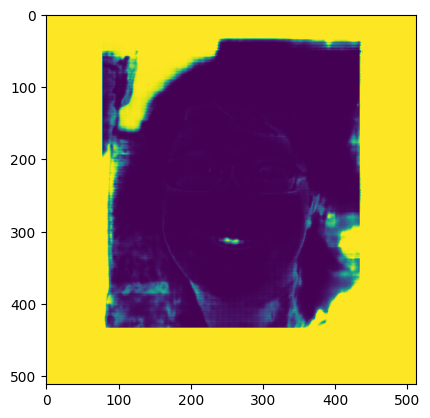

In [ ]:
plt.imshow(pred[1][0].detach().cpu().numpy())